# Постановка задач
существует мировая сеть приемников ГНСС. Данные этой сети можно использовать для исследования влияния движения МКС на атмосферу (ионосферу)

## до начала работы необходимо поставить пакет coordinates (conda install coordinates / pip install coordinates)

In [1]:
import numpy as np
import pandas as pd              # работа с таблицами
import matplotlib.pyplot as plt  # графики
#from geopy import distance
from math import radians, cos, sin, asin, sqrt
from numba import jit, njit
import pickle
import datetime as dt

In [2]:
# данные о пролетах МКС за 2014 год:

#file = 'C:/Users/anisi/Downloads/diplom/ISS_2014-01.h5'
#data = pd.read_hdf(file)  
#data['time'] = data.index
#data.index = range(data.shape[0])
#data.columns = 'lat lon alt time'.split()
#data['time lat lon alt'.split()]

In [3]:
#data = pd.read_csv('temp.csv', names='time lat lon alt'.split(),skiprows=1)
file = 'C:/Users/anisi/Downloads/diplom/ISS_2014-01.h5'
data = pd.read_hdf(file) 
data.columns = 'lat lon alt'.split()
#data.index = pd.to_datetime(data.time)
#data.drop('time', axis=1, inplace=True)

In [4]:
lat_rad = []
lon_rad = []
data['lat_rad'] = np.deg2rad(data.lat)
data['lon_rad'] = np.deg2rad(data.lon)
data

,lat,lon,alt,lat_rad,lon_rad
2014-01-01 00:00:00,-50.333535,-0.742741,433.111337,-0.878486,-0.012963
2014-01-01 00:00:01,-50.349450,-0.649372,433.114031,-0.878764,-0.011334
2014-01-01 00:00:02,-50.365284,-0.555937,433.116692,-0.879040,-0.009703
2014-01-01 00:00:03,-50.381035,-0.462438,433.119321,-0.879315,-0.008071
2014-01-01 00:00:04,-50.396704,-0.368874,433.121917,-0.879588,-0.006438
...,...,...,...,...,...
2014-01-31 23:59:55,-17.963539,118.341107,422.706148,-0.313523,2.065442
2014-01-31 23:59:56,-18.012730,118.381124,422.724068,-0.314381,2.066140
2014-01-31 23:59:57,-18.061910,118.421165,422.742003,-0.315240,2.066839
2014-01-31 23:59:58,-18.111080,118.461230,422.759953,-0.316098,2.067538


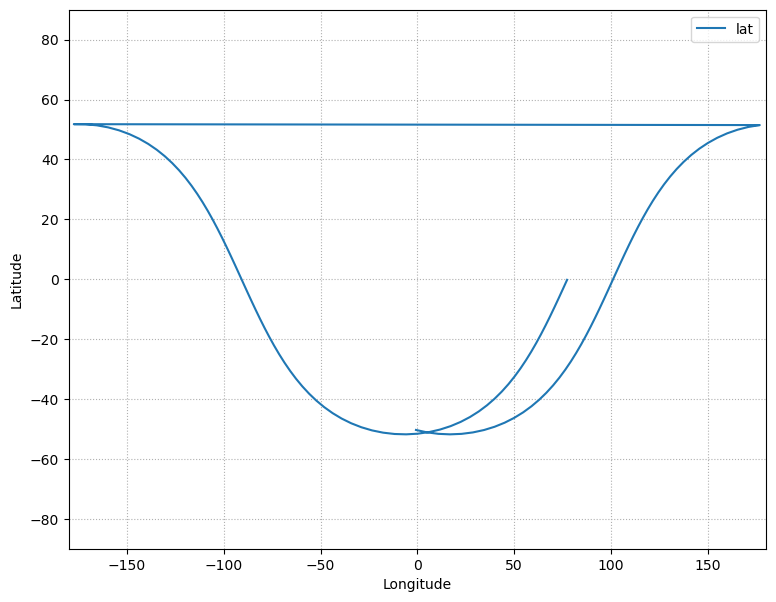

In [5]:
# Подготовим рисунок:
fig, ax = plt.subplots(figsize=(9,7))

data.columns = 'lat', 'lon', 'alt', 'lat_rad', 'lon_rad'
minute_resolution = data[::60]
minute_resolution[:120].plot(x='lon', y='lat', ax=ax)

plt.grid(ls=":")
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [6]:
minute_resolution[:120].index

DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 00:01:00',
               '2014-01-01 00:02:00', '2014-01-01 00:03:00',
               '2014-01-01 00:04:00', '2014-01-01 00:05:00',
               '2014-01-01 00:06:00', '2014-01-01 00:07:00',
               '2014-01-01 00:08:00', '2014-01-01 00:09:00',
               ...
               '2014-01-01 01:50:00', '2014-01-01 01:51:00',
               '2014-01-01 01:52:00', '2014-01-01 01:53:00',
               '2014-01-01 01:54:00', '2014-01-01 01:55:00',
               '2014-01-01 01:56:00', '2014-01-01 01:57:00',
               '2014-01-01 01:58:00', '2014-01-01 01:59:00'],
              dtype='datetime64[ns]', length=120, freq='60S')

## задача 1: 
нам нужно определить даты и интервалы времени, когда МКС находилась над областями плотного расположения приемников.
Мы возьмем три региона: Калифорния, Япония и Европа

In [7]:
path = './regions'
stations = []  # список, содержащий таблицы по каждому из трех регионов
for region in 'cal', 'jap', 'eur':
    stations.append(pd.read_csv(f'{path}/{region}.lst', names='site lat lon'.split()))
    

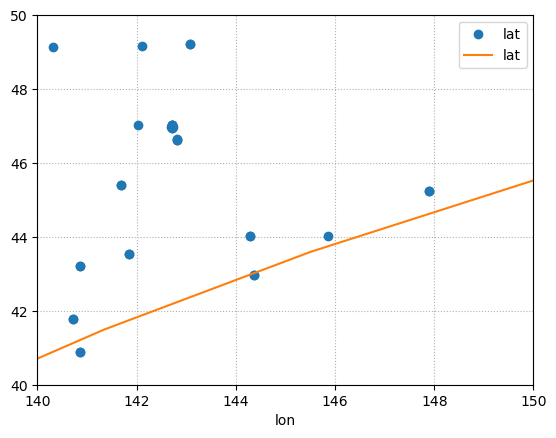

In [8]:
sites = stations[1]# это первые 10 станций в Калифорнии
fig, ax = plt.subplots(1)
sites.plot(x='lon', y='lat', marker='o', ls=' ', ax=ax)
minute_resolution[:120].plot(x='lon', y='lat',ax=ax)
plt.xlim(140, 150)
plt.ylim(40, 50)
plt.grid(ls=":")

In [60]:
sites = stations[1]
sites


,site,lat,lon
0,0194,39.1859,139.5477
1,019b,39.1859,139.5477
2,aira,31.8244,130.5996
3,ccj2,27.0678,142.1950
4,chan,43.7910,125.4442
...,...,...,...
187,khab,48.4954,135.0499
188,uskh,47.0350,142.7165
189,plvs,30.8431,121.5215
190,prt2,43.1226,133.1261


    site      lat       lon
31  g203  42.9759  144.3714
70  p203  42.9759  144.3714


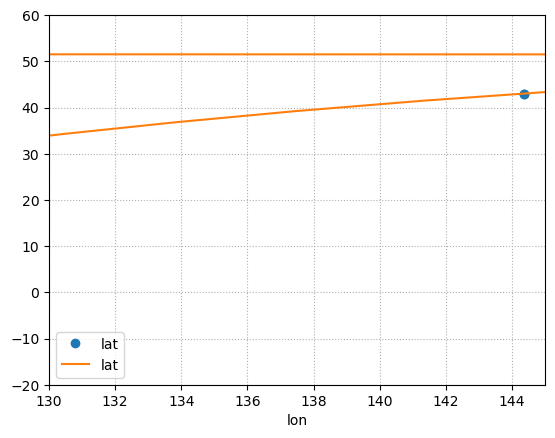

In [62]:
m = sites[(sites['lon'] > 144) & (sites['lat'] < 44)]
print(m)
fig, ax = plt.subplots(1)
m.plot(x='lon', y='lat', marker='o', ls=' ', ax=ax)
minute_resolution[:120].plot(x='lon', y='lat',ax=ax)
plt.xlim(130, 145)
plt.ylim(-20, 60)
plt.grid(ls=":")

Написать функцию: для заданной станции она возвращает моменты времени, когда МКС проходила над станцией (или в заданном радиусе от нее)

In [50]:
site = sites.iloc[31]
print(site)

site        g203
lat      42.9759
lon     144.3714
Name: 31, dtype: object


In [12]:
def when_iss_passed(station, iss_track, r = 0):
    radius = r / (2 * 6371) 
    s_lat = np.deg2rad(station.lat)
    s_lon = np.deg2rad(station.lon)
    gr_lat = radius/ 111.11 #градусы отбора
    gr_lon = gr_lat / cos(s_lat)
    data2 = data[['lat', 'lon', 'lat_rad', 'lon_rad']].copy()
    data2['station_name'] = station.site
    data2['dlat'] = data2.lat_rad-s_lat
    data2['dlon'] = data2.lon_rad-s_lon
    data2 = data2[(data2['dlat'] < gr_lat) & (data2['dlon'] < gr_lon)]
    data2['sin_dlat2'] = np.sin(data2.dlat/2)**2
    data2['sin_dlon2'] = np.sin(data2.dlon/2)**2
    data2['cos_s_lat'] = np.cos(s_lat)
    data2['cos_lat'] = np.cos(data2.lat_rad)
    data2['arcsin'] = np.arcsin((np.sqrt(data2.sin_dlat2 + data2.cos_lat * data2.cos_s_lat * data2.sin_dlon2)))
    data2 = data2[data2['arcsin'] < radius]
    data2 = data2[['lat', 'lon']]
    return data2

d = when_iss_passed(site, data, 200)
d

,lat,lon
2014-01-01 00:41:15,42.031610,142.353480
2014-01-01 00:41:16,42.067389,142.421706
2014-01-01 00:41:17,42.103122,142.490014
2014-01-01 00:41:18,42.138808,142.558402
2014-01-01 00:41:19,42.174449,142.626872
...,...,...
2014-01-31 12:32:54,42.381785,144.040834
2014-01-31 12:32:55,42.417122,144.109900
2014-01-31 12:32:56,42.452413,144.179048
2014-01-31 12:32:57,42.487656,144.248278


In [13]:
test = dict()
for i in sites.index[:]:
    item = sites.iloc[i]
    d = when_iss_passed(item, data, 200)
    test[item.site] = d
#на годовой файл ~16 минут, на месяц ~2 минуты 

In [14]:
pickle.dump(test, open('jap_one_month.pkl', 'wb'))

In [15]:
test2 = pickle.load(open('jap_one_month.pkl', 'rb'))
test2

{'0194':                            lat         lon
 2014-01-01 00:39:57  39.107902  137.273760
 2014-01-01 00:39:58  39.146947  137.335964
 2014-01-01 00:39:59  39.185953  137.398241
 2014-01-01 07:10:11  39.186288  138.449742
 2014-01-01 07:10:12  39.147323  138.511950
 ...                        ...         ...
 2014-01-31 12:31:26  39.100499  138.273621
 2014-01-31 12:31:27  39.139564  138.335836
 2014-01-31 12:31:28  39.178590  138.398125
 2014-01-31 19:01:41  39.189668  139.450019
 2014-01-31 19:01:42  39.150654  139.512323
 
 [232 rows x 2 columns],
 '019b':                            lat         lon
 2014-01-01 00:39:57  39.107902  137.273760
 2014-01-01 00:39:58  39.146947  137.335964
 2014-01-01 00:39:59  39.185953  137.398241
 2014-01-01 07:10:11  39.186288  138.449742
 2014-01-01 07:10:12  39.147323  138.511950
 ...                        ...         ...
 2014-01-31 12:31:26  39.100499  138.273621
 2014-01-31 12:31:27  39.139564  138.335836
 2014-01-31 12:31:28  39.178590  

Функция: на вход станция (имя, координаты), полный массив трека МКС, выход: словарь: имя станции, отобранные метки времени (отсчеты)

Обработать для всех станций, результат сохранить в pickle

## задача 2: 
Для заданного момента времени определить положение спутников GPS, GLONASS, таких, что лучи от них до заданной станции траекторию МКС

In [16]:
%pip install gnss_tec
%pip install git+https://github.com/gnss-lab/coordinates.git


  Cloning https://github.com/gnss-lab/coordinates.git to c:\users\anisi\appdata\local\temp\pip-req-build-bsss6b8u
  Resolved https://github.com/gnss-lab/coordinates.git to commit 3f61d5e7988c6d3030acec25a0823f60840c212b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/gnss-lab/coordinates.git 'C:\Users\anisi\AppData\Local\Temp\pip-req-build-bsss6b8u'


In [17]:
import gnss_tec
import datetime as dt
from coordinates import satellite_xyz
from sat_geometry_lite import xyz_to_el_az, sub_ionospheric

In [76]:
import json
# Читаем список станций
with open('base.json','rb') as file:
    sites = json.load(file) #10132 позиций

In [18]:
sat_num = 1
nav_file = 'C:/Users/anisi/Downloads/diplom/nav/brdc0030.14n'
gnss_type = 'G'
#g=gps, r=glonass

In [35]:
def temp(station, radius=0, **kwargs):
    path = kwargs.get('path', 'default__0')
    print(station, radius, path)
    

In [28]:
def temp(station, radius=0, path='default__0'):
    print(station, radius, path)
    

C:/Users/anisi/Downloads/diplom/nav/brdc0020.14d


In [106]:
temp ('qwe')
temp('sdfg', 56)
temp('sdfggfg', radius=123)

qwe 0 default__0
sdfg 56 default__0
sdfggfg 123 3


In [37]:
temp('asdf', path='c:\\')

asdf 0 c:\


In [ ]:
timestamp = dt.datetime(2014, 1, 1, 1,1,1)
site_xyz = site['xyz']
sat_xyz = satellite_xyz(nav_file, gnss_type, sat_num, timestamp)
sat_xyz

In [98]:
base_f = list()
for key in test2:
    a = key
    for i in range(1, 10133):
        site = sites[i]
        if site['code'] == a:
            base_f.append(site)

def sat_el_az (station, day, data, **kwargs): 
#для конкретного дня определяет номера спутников, которые видны для конкретной станции в моменты времени пролета МКС и находятся выше 30 градусов
    gnss_type = kwargs.get('gnss_type', 'G')
    day2 = day.strftime('%j')
    if gnss_type == 'G':
        nav_file = 'C:/Users/anisi/Downloads/diplom/nav/brdc' + day2 + '0.' + day.strftime('%y') + 'n'
    if gnss_type == 'R':
        nav_file = 'C:/Users/anisi/Downloads/diplom/nav/brdc' + day2 + '0.' + day.strftime('%y') + 'g'
    h = 455
    site_f = station
    code = site_f['code']
    ISS_track_over_station = data.get(code)
    time = ISS_track_over_station.index
    time = pd.to_datetime(time)
    time = time[time.date==day]
    gr_lat = 40
    gr_lon = 40 / cos(np.deg2rad(site_f['location']['lat']))
    sat = list()
    for i in range(1, 33):
        for t in time[:]:
            timestamp = t
            sat_num = i
            site_xyz = site_f['xyz']
            sat_xyz = satellite_xyz(nav_file, gnss_type, sat_num, timestamp)
            el, az = xyz_to_el_az(site_xyz, sat_xyz)
            if el >= 30:
                if sat_num not in sat:
                    sat.append(sat_num)
    return sat

station = base_f[31]
day_test = dt.date(2014,1,1)
sat = sat_el_az(station, day_test, test2, gnss_type = 'G')
print(sat)
sat2 = sat[1]

def get_crossections(satellite, station, data, day, **kwargs): 
#для каждого спутника и конкретной станции расширяет временной диапазон -10 +30 минут, рассчитывает ионосферную точку и проводит отбор по расстоянию от точек трека
    gnss_type = kwargs.get('gnss_type', 'G')
    day2 = day.strftime('%j')
    if gnss_type == 'G':
        nav_file = 'C:/Users/anisi/Downloads/diplom/nav/brdc' + day2 + '0.' + day.strftime('%y') + 'n'
    if gnss_type == 'R':
        nav_file = 'C:/Users/anisi/Downloads/diplom/nav/brdc' + day2 + '0.' + day.strftime('%y') + 'g'
    site_f = station
    site_xyz = site_f['xyz']
    code = site_f['code']
    ISS_track_over_station = data.get(code)
    time = ISS_track_over_station.index
    time = pd.to_datetime(time)
    time = time[time.date==day]
    h = 455
    time_min = time.min().round('min')
    min = time.min().round('min')-dt.timedelta(minutes=10)
    max = time.max().round('min')+dt.timedelta(minutes=30)
    time2 = pd.date_range(min, max, freq='30S')
    df = pd.DataFrame(columns=['timestamp', 'ionospheric_lat', 'ionospheric_lon'])
    ion_lat = list()
    ion_lon = list()
    ts = list()
    for timestamp in time2[:]:
        sat_xyz = satellite_xyz(nav_file, gnss_type, satellite, timestamp)
        el, az = xyz_to_el_az(site_xyz, sat_xyz)
        lat, lon = sub_ionospheric(site_f['location']['lat'], site_f['location']['lon'], h, az, el)
        ion_lat.append(lat)
        ion_lon.append(lon)
        ts.append(timestamp)
    df['timestamp'] = ts
    df['ionospheric_lat'] = ion_lat
    df['ionospheric_lon'] = ion_lon
    return df, time_min
    
gc = get_crossections(sat2, station, test2, day_test)

def sort(data, df_gc, **kwargs):
#возвращает датафрейм для конкретных спутников с координатами ионосферных точек, которые находились в радиусе 1000км от первой точки трека МКС
    radius = kwargs.get('radius', 1000)
    r = radius / (2 * 6371) 
    df = df_gc[0]
    df['ionospheric_lat_rad'] = np.deg2rad(df.ionospheric_lat)
    df['ionospheric_lon_rad'] = np.deg2rad(df.ionospheric_lon)
    ISS_lat = data.loc[df_gc[1]]['lat_rad']
    ISS_lon = data.loc[df_gc[1]]['lon_rad']
    #print(data.loc[df_gc[1]]['lat'], data.loc[df_gc[1]]['lon'])
    df['dlat'] = df.ionospheric_lat_rad-ISS_lat
    df['dlon'] = df.ionospheric_lon_rad-ISS_lon
    df['sin_dlat2'] = np.sin(df.dlat/2)**2
    df['sin_dlon2'] = np.sin(df.dlon/2)**2
    df['cos_ISS_lat'] = np.cos(ISS_lat)
    df['cos_lat'] = np.cos(df.ionospheric_lat_rad)
    df['arcsin'] = np.arcsin(np.sqrt(df.sin_dlat2 + df.cos_ISS_lat * df.cos_lat * df.sin_dlon2))
    df = df[['ionospheric_lat', 'ionospheric_lon']]
    #df = df[df['arcsin'] < r]
    #df = df[['ionospheric_lat', 'ionospheric_lon']]
    return df

sort(data, gc, radius=1000)

[4, 10, 13, 17, 20, 23]


,ionospheric_lat,ionospheric_lon
0,-1.014426,138.104709
1,-1.027189,138.121520
2,-1.044387,138.135073
3,-1.068258,138.144896
4,-1.103748,138.149280
...,...,...
78,0.081433,137.754304
79,-0.250740,137.971174
80,-0.547148,138.110498
81,-0.752100,138.176167


{'code': 'g203', 'ftps': ['igs.gnsswhu.cn', 'garner.ucsd.edu', 'lox.ucsd.edu'], 'height': 4610.6, 'location': {'lat': 42.9759022, 'lon': 144.3713932}, 'xyz': [-3798934.39, 2722639.84, 4325540.46]}


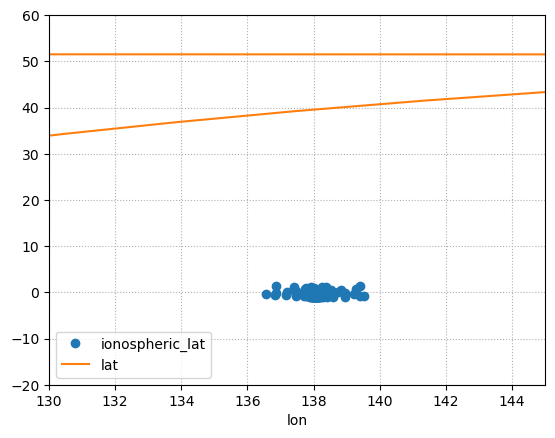

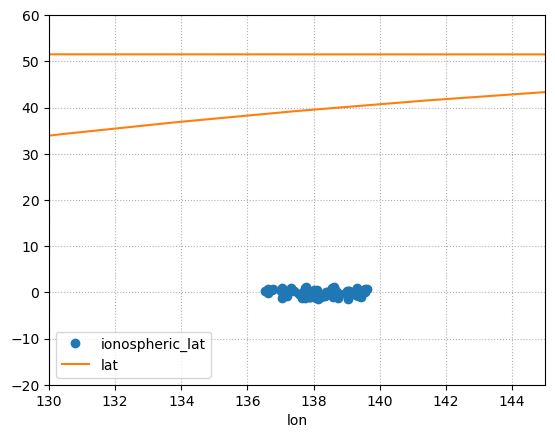

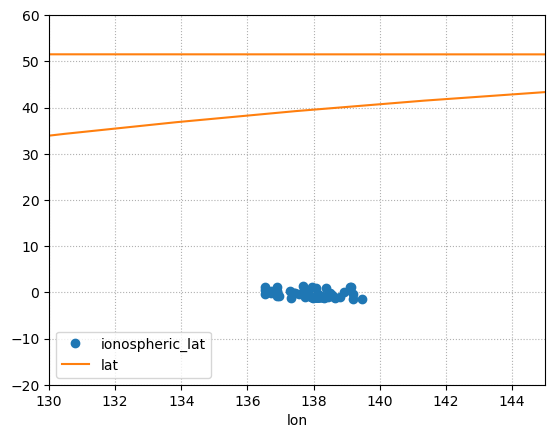

In [99]:
station = base_f[31]
print(station)
day_test = dt.date(2014,1,31)
sat = sat_el_az(station, day_test, test2, gnss_type = 'G')
if len(sat) != 0:
    for m in range(0, len(sat)):
        satellite = sat[m]
        gc = get_crossections(satellite, station, test2, day_test)
        result = sort (data, gc)
        fig, ax = plt.subplots(1)
        result.plot(x='ionospheric_lon', y='ionospheric_lat', marker='o', ls=' ', ax=ax)
        minute_resolution[:120].plot(x='lon', y='lat',ax=ax)
        plt.xlim(130, 145)
        plt.ylim(-20, 60)
        plt.grid(ls=":")

In [84]:
for i in range(0, len(base_f)):
    station = base_f[i]
    for a in range(1,32):
        day_test = dt.date(2014,1,a)
        sat = sat_el_az(station, day_test, test2, gnss_type = 'G')
        if len(sat) != 0:
            for m in range(0, len(sat)):
                satellite = sat[m]
                gc = get_crossections(satellite, station, test2, day_test)
                result = sort (data, gc)
                print(result)

Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Columns: [ionospheric_lat, ionospheric_lon]
Index: []
Empty DataFrame
Colu

In [87]:
pd.to_datetime(sat)
print(type(sat))
sat[sat.date == dt.date(2014,1,3)]

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


DatetimeIndex(['2014-01-03 16:03:42', '2014-01-03 16:03:43',
               '2014-01-03 16:03:44', '2014-01-03 16:03:45',
               '2014-01-03 16:03:46', '2014-01-03 16:03:47',
               '2014-01-03 16:03:48', '2014-01-03 16:03:49',
               '2014-01-03 16:03:50', '2014-01-03 16:03:51',
               '2014-01-03 16:03:52', '2014-01-03 16:03:53',
               '2014-01-03 16:03:54', '2014-01-03 16:03:55',
               '2014-01-03 16:03:56', '2014-01-03 16:03:57',
               '2014-01-03 16:03:58'],
              dtype='datetime64[ns]', freq=None)

In [29]:
for i in range(35):
    sliced_index = t[t.day==i]
    print(i, len(sliced_index))
    for t in sliced_index:
        continue

0 0
1 2778
2 2880
3 2880
4 2880
5 2880
6 2880
7 2880
8 2880
9 2880
10 2880
11 2880
12 2880
13 2880
14 2880
15 2880
16 2880
17 2880
18 2880
19 2880
20 2880
21 2880
22 2880
23 2880
24 2880
25 2880
26 2880
27 2880
28 2880
29 2880
30 2880
31 1607
32 0
33 0
34 0


In [93]:
for i in range(1,32):
    day = dt.date(2014,1,i)
    print(day)

2014-01-01
2014-01-02
2014-01-03
2014-01-04
2014-01-05
2014-01-06
2014-01-07
2014-01-08
2014-01-09
2014-01-10
2014-01-11
2014-01-12
2014-01-13
2014-01-14
2014-01-15
2014-01-16
2014-01-17
2014-01-18
2014-01-19
2014-01-20
2014-01-21
2014-01-22
2014-01-23
2014-01-24
2014-01-25
2014-01-26
2014-01-27
2014-01-28
2014-01-29
2014-01-30
2014-01-31


In [ ]:
for i in base_f.index[:]:
    item = base_f[i]
    

In [ ]:
a, b = data.loc[t1]['lat lon'.split()]

In [ ]:
a, b

In [ ]:
time.min().round('min')-dt.timedelta(minutes=10), time.max().round('min')+dt.timedelta(minutes=30)

In [ ]:
# углы положения спутника на небе восхождение (elevation) и азимут (azimuth)
el, az = xyz_to_el_az(site_xyz, sat_xyz)
el, az

In [ ]:
# определение координат точки пересечения луча со слоем на высоте h
h = 455
sub_ionospheric(-12.4667792, 130.8439872, h, az, el)

In [ ]:
# функция возвращает нам моменты, когда лучи от станции до спутников ГНСС пересекали траекторию МКС
# опция radius дает допустимое расхождение между положением станции и ионосферной точкой (точкой пересечения) луча
def get_crossections(day, site, radius=0):
    
    pass

In [ ]:
sites[0]

In [103]:
temp_date = dt.datetime(2014,4,22)

In [104]:
temp_date.strftime('%j')

'112'

In [95]:
filename = 'brdc1120.14g'

In [100]:
dt.datetime.strptime(filename, 'brdc%j0.%yg')

datetime.datetime(2014, 4, 22, 0, 0)

In [ ]:
test2['cae1']

In [36]:
tt = pd.date_range(dt.datetime(2014,1,1,4,30,10), dt.datetime(2014,5,1,4,35), freq='30S')

In [42]:
tt[tt.date==dt.date(2014,2,2)]

DatetimeIndex(['2014-02-02 00:00:10', '2014-02-02 00:00:40',
               '2014-02-02 00:01:10', '2014-02-02 00:01:40',
               '2014-02-02 00:02:10', '2014-02-02 00:02:40',
               '2014-02-02 00:03:10', '2014-02-02 00:03:40',
               '2014-02-02 00:04:10', '2014-02-02 00:04:40',
               ...
               '2014-02-02 23:55:10', '2014-02-02 23:55:40',
               '2014-02-02 23:56:10', '2014-02-02 23:56:40',
               '2014-02-02 23:57:10', '2014-02-02 23:57:40',
               '2014-02-02 23:58:10', '2014-02-02 23:58:40',
               '2014-02-02 23:59:10', '2014-02-02 23:59:40'],
              dtype='datetime64[ns]', length=2880, freq='30S')